In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.animation as animation
from scipy.sparse import dok_matrix
import multiprocessing as mp
import scipy as sp
import matplotlib.ticker as ticker
import project

In [2]:
#General plot parameters and size definition
plt.style.use('science')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams.update({"axes.grid" : True})

In [3]:
#loading up the parameters

params_HH = project.utils.load_HH()
params_LIF = project.utils.load_LIF()
params_IZH = project.utils.load_ISH()
params_ML = project.utils.load_ML()

#time parameters
t_final = 1500
dt = 0.01

#Other constant parameters
num_neurons = 10
Isyn = 0.05
tau = 0.65
V0 = -65 * np.ones(num_neurons)
y0 = -65 * np.ones(num_neurons)
w0 = 0 * np.ones(num_neurons)
u0 = 0 * np.ones(num_neurons)
n0 = 0 * np.ones(num_neurons)
m0 = 0 * np.ones(num_neurons)
h0 = 0 * np.ones(num_neurons)
order = 5


#fixing random seed
np.random.seed(1234)

#generating the intensities
I_HH = np.zeros((int(t_final/dt),num_neurons))
I_IF = np.zeros((int(t_final/dt),num_neurons))
I_IZH = np.zeros((int(t_final/dt),num_neurons))
I_ML = np.zeros((int(t_final/dt),num_neurons))

for i in range(0,num_neurons):
    I_HH[:,i] = 2.5
    I_IF[:,i] = 2.5 
    I_IZH[:,i] = 2.5
    I_ML[:,i] = 2.5

In [4]:
#Creating the Electrical and Chemical connectivity matrices, in this case for 10 neurons
E_matrix,seed = project.utils.create_matrix('electrical',num_neurons,connection_fraction_e=1)
C_matrix, seed = project.utils.create_matrix('chemical',num_neurons,connection_fraction_c=1)

In [6]:
dataHH_adjust, matrixHH_adjust = project.models.rk_HH_Rossum(dt,t_final,order,V0,n0,m0,h0,*params_HH,I_HH,Isyn,0.0,tau,E_matrix,C_matrix,0)
dataIF_adjust, completeIF_adjust, matrixIF_adjust = project.models.rk_if_2_Rossum(dt, t_final,order,y0,*params_LIF,I_IF,Isyn,0.0,tau,1,E_matrix,C_matrix,0)
dataIZH_adjust, completeIZH_adjust, matrixIZH_adjust = project.models.rk_ish_2_Rossum(dt,t_final,order,y0,u0,I_IZH,Isyn,*params_IZH,0.0,tau,E_matrix,C_matrix,0)
dataML_adjust, matrixML_adjust = project.models.rk_ml_2_Rossum(dt,t_final,2,y0,w0,*params_ML,I_ML,Isyn,0.00,tau,E_matrix,C_matrix,0)

(1200.0, 1500.0)

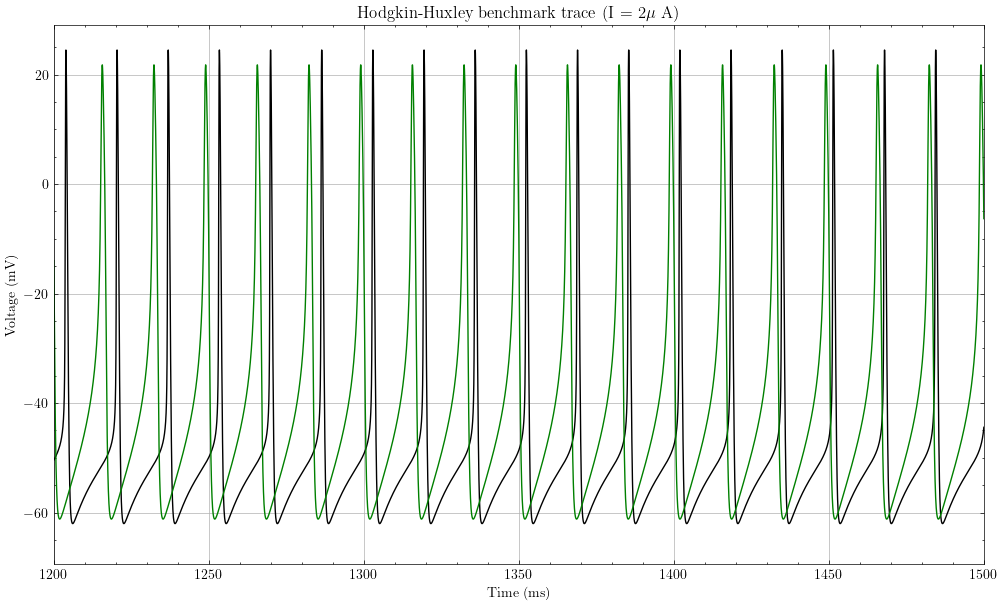

In [8]:
time = np.linspace(0,t_final,int(t_final/dt),)
plt.plot(time,dataHH_adjust[:,8], color = 'black')
plt.plot(time,dataML_adjust[:,8], color = 'green')
plt.title(r'Hodgkin-Huxley benchmark trace (I = 2$\mu$ A)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(1200,1500)

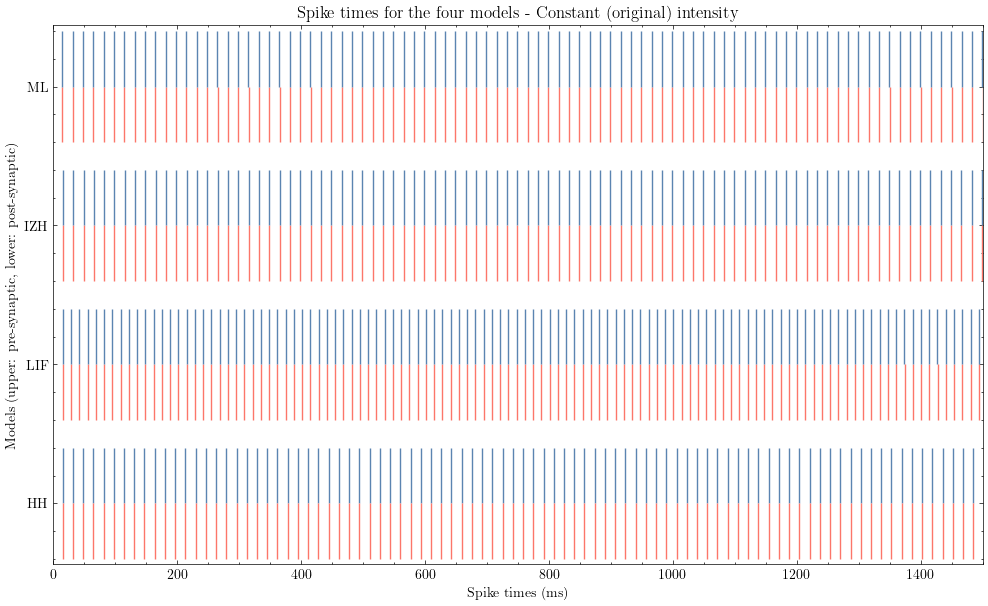

In [9]:
spike_HH_1 =  (np.argwhere(np.array(matrixHH_adjust.todense())[0,:]>0) * dt).flatten()
spike_HH_2 =  (np.argwhere(np.array(matrixHH_adjust.todense())[1,:]>0) * dt).flatten()
spike_IF_1 =  (np.argwhere(np.array(matrixIF_adjust.todense())[0,:]>0) * dt).flatten()
spike_IF_2 =  (np.argwhere(np.array(matrixIF_adjust.todense())[1,:]>0) * dt).flatten()
spike_IZH_1 =  (np.argwhere(np.array(matrixIZH_adjust.todense())[0,:]>0) * dt).flatten()
spike_IZH_2 = (np.argwhere(np.array(matrixIZH_adjust.todense())[1,:]>0) * dt).flatten()
spike_ML_1 = (np.argwhere(np.array(matrixML_adjust.todense())[0,:]>0) * dt).flatten()
spike_ML_2 = (np.argwhere(np.array(matrixML_adjust.todense())[1,:]>0) * dt).flatten()
fig, ax = plt.subplots()

ax.eventplot(spike_HH_1, color = '#5B84B1FF')
ax.eventplot(spike_HH_2,color='#FC766AFF',lineoffsets=0,label='hola')
ax.eventplot(spike_IF_2,color = '#FC766AFF',lineoffsets=2.5)
ax.eventplot(spike_IF_1, color = '#5B84B1FF', lineoffsets= 3.5)
ax.eventplot(spike_IZH_2,color = '#FC766AFF',lineoffsets= 5.0 )
ax.eventplot(spike_IZH_1, color = '#5B84B1FF', lineoffsets= 6.0)
ax.eventplot(spike_ML_2, color = '#FC766AFF', lineoffsets= 7.5)
ax.eventplot(spike_ML_1,color = '#5B84B1FF', lineoffsets= 8.5)
ax.grid()
ax.set_ylim(-0.6,9.1)
ax.set_ylabel('Models (upper: pre-synaptic, lower: post-synaptic)')
plt.yticks((0.5,3.0,5.5,8.0))
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'HH'
labels[1] = 'LIF'
labels[2] = 'IZH'
labels[3] = 'ML'

ax.set_yticklabels(labels, color = 'black')
ax.set_xlabel('Spike times (ms)')
ax.set_xlim(0,1500)

plt.title('Spike times for the four models - Constant (original) intensity')
plt.show()

In [10]:
firing_HH_pre = len(spike_HH_1)  * 1000 / t_final 
firing_HH_post = len(spike_HH_2)   *1000 / t_final
firing_IF_pre = len(spike_IF_1)  * 1000 / t_final 
firing_IF_post = len(spike_IF_2)  *1000 / t_final
firing_IZH_pre = len(spike_IZH_1)  * 1000 / t_final 
firing_IZH_post = len(spike_IZH_2)  *1000 / t_final
firing_ML_pre = len(spike_ML_1)  * 1000 / t_final 
firing_ML_post = len(spike_ML_2) *1000 / t_final

print('Pre-synaptic firing rates \n HH:',firing_HH_pre,'IF:',firing_IF_pre, 'IZH:', firing_IZH_pre, 'ML:', firing_ML_pre )
print('Post-synaptic firing rates \n HH:',firing_HH_post,'IF:',firing_IF_post, 'IZH:', firing_IZH_post, 'ML:', firing_ML_post )


Pre-synaptic firing rates 
 HH: 60.0 IF: 74.66666666666667 IZH: 60.0 ML: 60.0
Post-synaptic firing rates 
 HH: 60.0 IF: 74.66666666666667 IZH: 60.0 ML: 60.0
